In [1]:
import os
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

def correlate(e1, e2=None):
    if e2 is None:
        e2 = e1
    return e1 @ e2.T

def correlate_minus_diag(e1):
    correlation = e1 @ e1.T
    return correlation - (1 - correlation.mean()) * np.eye(correlation.shape[0])

with open('.env') as f:
    openai.api_key = f.read().strip().split('=')[1]

anthems_dir = Path('data/anthems')
file_paths = {}
lyrics = {}
embeddings = {}

for g in anthems_dir.glob('*.txt'):
    stem = g.stem
    file_paths[stem] = g
    
    with open(g) as f:
        lyrics[stem] = np.asarray([line.strip() for line in f.readlines() if line.strip() != ""])

    emb_path = g.with_suffix('.emb')
    if os.path.isfile(emb_path):
        print(f"Loading {stem} from file")
        embeddings[stem] = np.loadtxt(emb_path)
    else:
        print(f"Fetching {stem} from OpenAI")
        response = openai.Embedding.create(input=list(lyrics[stem]), model="text-embedding-ada-002")
        embeddings[stem] = np.asarray([e.embedding for e in response['data']])
        np.savetxt(emb_path, embeddings[stem])

Loading USA from file
Loading RUS from file
Loading CAN from file
Loading GBR from file
Loading NZL from file
Loading PRK from file
Loading AUS from file
Loading KOR from file


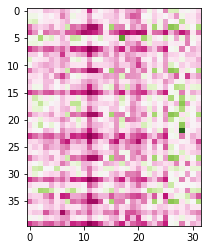

In [112]:
plt.imshow(correlate(embeddings['NZL'], embeddings['USA']), cmap='PiYG')

In [115]:
country1 = 'USA'
country2 = 'NZL'
c = correlate(embeddings[country1], embeddings[country2])
idx1, idx2 = np.unravel_index(c.argmax(), c.shape)

print(c.max())

lyrics[country1][idx1], lyrics[country2][idx2]

0.9109301072673278


('Then conquer we must, when our cause it is just,',
 'Let our cause be just and right,')

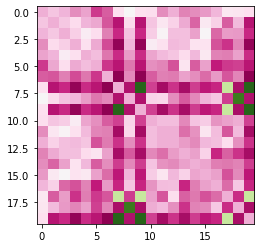

In [116]:
plt.imshow(correlate_minus_diag(embeddings['AUS']), cmap='PiYG')

(array([ 56.,  90., 124.,  78.,  38.,   0.,   6.,   0.,   0.,   8.]),
 array([0.73838607, 0.76454747, 0.79070886, 0.81687026, 0.84303165,
        0.86919305, 0.89535445, 0.92151584, 0.94767724, 0.97383863,
        1.00000003]),
 <BarContainer object of 10 artists>)

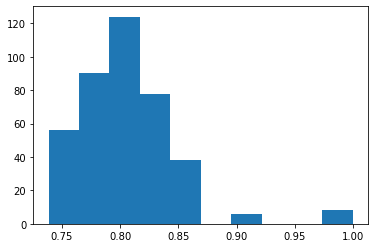

In [118]:
plt.hist(correlate_minus_diag(embeddings['AUS']).ravel())

In [119]:
for key in embeddings.keys():
    print(key, embeddings[key].shape)

USA (32, 1536)
RUS (20, 1536)
CAN (10, 1536)
GBR (21, 1536)
NZL (40, 1536)
PRK (24, 1536)
AUS (20, 1536)
KOR (16, 1536)


In [43]:
anglo_countries = ['USA', 'CAN', 'GBR', 'AUS', 'NZL']

anglo_lyrics = pd.concat(pd.DataFrame({'lyric': lyrics[country], 'country': country}).reset_index().set_index(['country', 'index']) for country in anglo_countries)
anglo_embeddings = np.vstack([embeddings[country] for country in anglo_countries])

print(len(anglo_lyrics))
print(anglo_embeddings.shape)

123
(123, 1536)


In [111]:
n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(anglo_embeddings)
anglo['cluster'] = kmeans.labels_
anglo

lyric  cluster
country index                                                            
USA     0          O say can you see, by the dawn's early light,        6
        1      What so proudly we hailed at the twilight's la...        6
        2      Whose broad stripes and bright stars through t...        5
        3      O'er the ramparts we watched, were so gallantl...        5
        4      And the rocket's red glare, the bombs bursting...        5
...                                                          ...      ...
NZL     35                             God defend our free land.        9
        36                        Guide her in the nations' van,        6
        37                      Preaching love and truth to man,        6
        38                        Working out Thy glorious plan,        2
        39                               God defend New Zealand.        4

[123 rows x 2 columns]

In [112]:
anglo[anglo['cluster'] == 3]

lyric  cluster
country index                                          
AUS     0      Australians all let us rejoice,        3
        7              Advance Australia fair!        3
        9              Advance Australia fair!        3
        17          To advance Australia fair.        3
        19             Advance Australia fair!        3

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

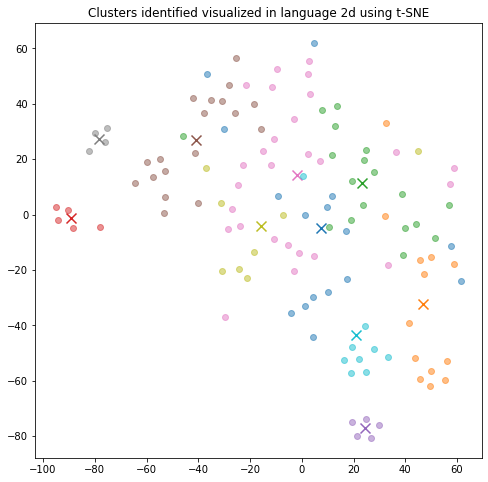

In [113]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(anglo_embeddings)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

fig, ax = plt.subplots(figsize=(8,8))


# ["purple", "green", "red", "blue", "black"]
for category, color in enumerate(mpl.cm.get_cmap('tab10')([n/10 for n in range(n_clusters)])):
    xs = np.array(x)[anglo.cluster == category]
    ys = np.array(y)[anglo.cluster == category]
    ax.scatter(xs, ys, color=color, alpha=0.5)

    avg_x = xs.mean()
    avg_y = ys.mean()

    ax.scatter(avg_x, avg_y, marker="x", color=color, s=100)
ax.set_title("Clusters identified visualized in language 2d using t-SNE")

In [116]:
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    lyrics = "\n".join(
        anglo[anglo.cluster == i]
        .lyric
        .sample(rev_per_cluster, random_state=42, replace=True)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following lyrics have in common?\n\nLyrics:\n"""\n{lyrics}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = anglo[anglo.cluster == i].sample(rev_per_cluster, random_state=42, replace=True)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.lyric.values[j])

    print("-" * 100)

Cluster 0 Theme:  Protection and defense of a country
Asking Thee to bless this place,
May he defend our laws,
Let our cause be just and right,
Guard our country's spotless name,
But, should foes assail our coast,
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  The lyrics all contain references to God and prayer.
O Lord our God arise,
God save the King!
May Thy blessings never cease,
God of Nations at Thy feet,
God save us all!
----------------------------------------------------------------------------------------------------
Cluster 2 Theme:  Unity
To sing with heart and voice,
Gather here before Thy face,
With courage let us all combine
For we are one and free;
To sing with heart and voice,
----------------------------------------------------------------------------------------------------
Cluster 3 Theme:  The lyrics all share the same theme of patriotism for Australia.
To advance Australia fair.
Advance Austral